<a href="https://colab.research.google.com/github/kenclements/praxis/blob/main/adaboost-twos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!nvidia-smi

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import string
import re

#Vectorization and Tokenizing
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MaxAbsScaler



#Models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression


#Metrics and Testing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
# file1 = pd.read_csv('/Data/TWOS-dataset/email_ano/User1.csv')
# file2 = pd.read_csv('/Data/TWOS-dataset/email_ano/User2.csv')
# file3 = pd.read_csv('/Data/TWOS-dataset/email_ano/User3.csv')
# file4 = pd.read_csv('/Data/TWOS-dataset/email_ano/User4.csv')
# file6 = pd.read_csv('/Data/TWOS-dataset/email_ano/User6.csv')
# file7 = pd.read_csv('/Data/TWOS-dataset/email_ano/User7.csv')
# file8 = pd.read_csv('/Data/TWOS-dataset/email_ano/User8.csv')
# file9 = pd.read_csv('/Data/TWOS-dataset/email_ano/User9.csv')
# file10 = pd.read_csv('/Data/TWOS-dataset/email_ano/User10.csv')
# file11 = pd.read_csv('/Data/TWOS-dataset/email_ano/User11.csv')
# file12 = pd.read_csv('/Data/TWOS-dataset/email_ano/User12.csv')
# file13 = pd.read_csv('/Data/TWOS-dataset/email_ano/User13.csv')
# file14 = pd.read_csv('/Data/TWOS-dataset/email_ano/User14.csv')
# file15 = pd.read_csv('/Data/TWOS-dataset/email_ano/User15.csv')
# file16 = pd.read_csv('/Data/TWOS-dataset/email_ano/User16.csv')
# file17 = pd.read_csv('/Data/TWOS-dataset/email_ano/User17.csv')
# file18 = pd.read_csv('/Data/TWOS-dataset/email_ano/User18.csv')
# file19 = pd.read_csv('/Data/TWOS-dataset/email_ano/User19.csv')
# file20 = pd.read_csv('/Data/TWOS-dataset/email_ano/User20.csv')
# file21 = pd.read_csv('/Data/TWOS-dataset/email_ano/User21.csv')
# file22 = pd.read_csv('/Data/TWOS-dataset/email_ano/User22.csv')
# file23 = pd.read_csv('/Data/TWOS-dataset/email_ano/User23.csv')
# combined = pd.read_csv('/Data/TWOS-dataset/email_ano/combined.csv')
#test = pd.read_csv('/Data/TWOS-dataset/email_ano/test.csv')
#train = pd.read_csv('/Data/TWOS-dataset/email_ano/train.csv')
imdb = pd.read_csv('/Data/TWOS-dataset/email_ano/IMDB Dataset.csv')



In [3]:
df = imdb
#df = pd.concat([file1, file2, file3, file4, file6, file7, file8, file9, file10, file11, file12, file13, file14, file15, file16, file17, file18, file19, file20, file21, file22, file23])

In [4]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
df.rename(columns={"review": "body_anon", "sentiment": "label"}, inplace=True)

<AxesSubplot: >

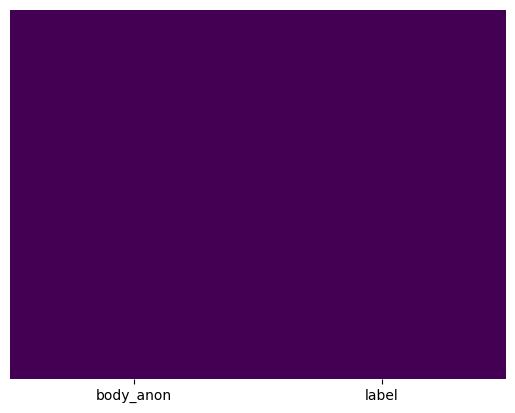

In [6]:
sb.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [7]:
df['label']

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: label, Length: 50000, dtype: object

In [8]:
df.dropna(subset=['label'], inplace=True)


In [9]:
#df['body_anon'] = df['body_anon'].astype(str)

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer


In [11]:
df

,body_anon,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [12]:
def prep(dfx):
    dfx1 = [re.sub(r'[^\w\s]','', x) for x in dfx]
    dfx1 = ''.join(dfx1)
    return(dfx1)

df1 = df['body_anon'].apply(prep)

In [13]:
stops = set(stopwords.words('english'))
#print(stops)

In [14]:
def prepare_text(pretext):

    # tokenize mission.
    tokens = word_tokenize(pretext, language="english", preserve_line=True)

    # Parts of speech (POS) tag tokens.
    token_tag = pos_tag(tokens)
    
    # Only include some of the POS tags.
    include_tags = ['VBN', 'VBD', 'JJ', 'JJS', 'JJR', 'CD', 'NN', 'NNS', 'NNP', 'NNPS']
    filtered_tokens = (tok for tok, tag in token_tag if tag in include_tags)    
    #stem words.
    stemmed_tokens = (lancaster.stem(tok) for tok in filtered_tokens)

    #lemm words.
    lemmed_words = (lemmatizer.lemmatize(tok) for tok in stemmed_tokens)

    lower_words = [str.lower(tok) for tok in lemmed_words]

    #x = cv.fit_transform(tokens).toarray()

    joined = " ".join(lower_words);

    return(joined)

    #ps = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
    
df['tokenized'] = df['body_anon'].apply(prepare_text)


In [15]:
df.head(1)


,body_anon,label,tokenized
0,One of the other reviewers has mentioned that ...,positive,on oth review ment 1 oz episod hooked. right h...


In [16]:
countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
tfidfvectorizer = TfidfVectorizer(stop_words=None, analyzer='word' )

In [17]:
count_wm = countvectorizer.fit_transform(df['body_anon'])
tfidf_wm = tfidfvectorizer.fit_transform(df['tokenized'])


In [18]:
count_tokens = countvectorizer.get_feature_names_out()
tfidf_tokens = tfidfvectorizer.get_feature_names_out()

In [19]:
df_countvect = pd.DataFrame(data = count_wm.toarray(),columns = count_tokens)
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)
print("Count Vectorizer\n")
print(df_countvect)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect)

MemoryError: Unable to allocate 29.8 GiB for an array with shape (50000, 79867) and data type float64

In [19]:
df = df.reset_index(drop=True)


In [20]:
print(df.loc[50, 'tokenized'])

return 36th chamb on class kung-fu movy shaw 70 80 genr equ spaghett western hollywood protagon gordon liu counterpart western clint eastwood. digit remast new print mad fantast film fest pres shaw scop good old days. < br / > < br / > film simpl story good vers evil told 3 act sum nar mart art film era. < br / > < br / > act on premise. work dye-mill smal vil unhappy lot wag cut 20 % manchu gangsters. exploit non mart art skil gangst boss. first had min success liu skil shaolin monk on best comedy sequ rous got expo push limit cred on many times. br / > < br / > act two protagon mob. real mart art journey shaolin templ mart art sly. slapstick mom acceiv abbot imperson disappoint method kind mr miyag styl kar kid fent scaffold temple. noth good man strength end kung-fu unorthodox way. < br / > < br / > act three fight fest begins. cheesy sound effect obvy non-contact film giv maxim impact treatment. fight scen wid angl shot clar detail partn u slow-motion stunt diff spee fight slow pau

In [21]:

print(tfidf_wm[50])


  (0, 40017)	0.0696711746664531
  (0, 49506)	0.0699790743536971
  (0, 46606)	0.0864131279905618
  (0, 58260)	0.06347118065680667
  (0, 26180)	0.04513711589902062
  (0, 48331)	0.12675030226117515
  (0, 53650)	0.096287484073686
  (0, 78094)	0.1063393041820252
  (0, 79192)	0.0878169443119933
  (0, 52375)	0.08130941183448129
  (0, 67625)	0.06570340589516455
  (0, 47130)	0.0761414187475726
  (0, 52147)	0.06266322906134288
  (0, 14177)	0.07245296752288652
  (0, 77605)	0.06306004333991222
  (0, 72045)	0.087449441637624
  (0, 34636)	0.06112927237169373
  (0, 7462)	0.085163482361302
  (0, 74262)	0.09153839873193124
  (0, 67401)	0.06276632112173713
  (0, 69894)	0.09753143817401075
  (0, 61231)	0.11423535608740319
  (0, 25338)	0.08069349995096937
  (0, 46332)	0.10458328207978991
  (0, 34685)	0.08049538026293002
  :	:
  (0, 47315)	0.04814571123324739
  (0, 63497)	0.03906005681441947
  (0, 64694)	0.09720474558373078
  (0, 47282)	0.01692372730740916
  (0, 67675)	0.08890597441332669
  (0, 19925)	0.04

In [22]:
transformer = MaxAbsScaler().fit(tfidf_wm)
tfidf_wm = transformer.transform(tfidf_wm)

In [23]:
print(tfidf_wm[50])

  (0, 40017)	0.13012055829854566
  (0, 49506)	0.19458383465532839
  (0, 46606)	0.209668458757791
  (0, 58260)	0.1813245702340672
  (0, 26180)	0.1170736737716666
  (0, 48331)	1.0
  (0, 53650)	0.41910830633917895
  (0, 78094)	0.48520611474013203
  (0, 79192)	0.2843414098836297
  (0, 52375)	0.1702657384105507
  (0, 67625)	0.10112673618936814
  (0, 47130)	0.12313351583009842
  (0, 52147)	0.15263638665803064
  (0, 14177)	0.10358194873037005
  (0, 77605)	0.1706096485092719
  (0, 72045)	0.24547232262668195
  (0, 34636)	0.18468884059162954
  (0, 7462)	0.3930577091639077
  (0, 74262)	0.343117989101729
  (0, 67401)	0.17157891312907753
  (0, 69894)	0.3060709138078653
  (0, 61231)	0.36731042879561976
  (0, 25338)	0.11588972931128524
  (0, 46332)	0.18592930322384707
  (0, 34685)	0.1747933480698384
  :	:
  (0, 47315)	0.08897738729559596
  (0, 63497)	0.07178319714216333
  (0, 64694)	0.21599150030875494
  (0, 47282)	0.03150286163545965
  (0, 67675)	0.2585920727652392
  (0, 19925)	0.14353970258070778
 

In [24]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(tfidf_wm, df['label'], test_size=.3) # 70% training and 30% test


**This is the Keras TF-IDF vectorization method**

In [25]:
# text_vectorizer = layers.TextVectorization(output_mode="tf-idf", ngrams=1)
# text_vectorizer.adapt(df['tokenized'])
# keras_vector = text_vectorizer(df['tokenized']).numpy()
# X_train, X_test, y_train, y_test = train_test_split(keras_vector, df['label'], test_size=.5) # 70% training and 30% test


ADABOOST MODEL

In [26]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1) 
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)


In [27]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.789


In [28]:
confusion_matrix(y_test, y_pred)

array([[5622, 1843],
       [1322, 6213]], dtype=int64)

KNN Model

In [29]:
K = []
training = []
test = []
scores = {}
  
for k in range(2, 21):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
  
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)
  
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]

In [30]:
scores

{2: [0.78419452887538, 0.6568825910931174],
 3: [0.7912867274569402, 0.6103238866396761],
 4: [0.7446808510638298, 0.6568825910931174],
 5: [0.7507598784194529, 0.638663967611336],
 6: [0.7335359675785208, 0.680161943319838],
 7: [0.7375886524822695, 0.6447368421052632],
 8: [0.7173252279635258, 0.6892712550607287],
 9: [0.7254305977710233, 0.6791497975708503],
 10: [0.7112462006079028, 0.6892712550607287],
 11: [0.7183383991894631, 0.6821862348178138],
 12: [0.7082066869300911, 0.6953441295546559],
 13: [0.7244174265450861, 0.6862348178137652],
 14: [0.7112462006079028, 0.6902834008097166],
 15: [0.7365754812563323, 0.680161943319838],
 16: [0.7284701114488349, 0.6862348178137652],
 17: [0.7406281661600811, 0.6781376518218624],
 18: [0.7244174265450861, 0.6852226720647774],
 19: [0.7315096251266464, 0.6619433198380567],
 20: [0.7284701114488349, 0.6690283400809717]}

In [31]:
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [32]:
y_pred

array(['ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'NORMAL', 'ANOMALY', 'ANOMALY', 'NORMAL', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'NORMAL', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'NORMAL', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'NORMAL',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'NORMAL', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMA

In [33]:
confusion_matrix(y_test, y_pred)

array([[625,  61],
       [278,  24]], dtype=int64)

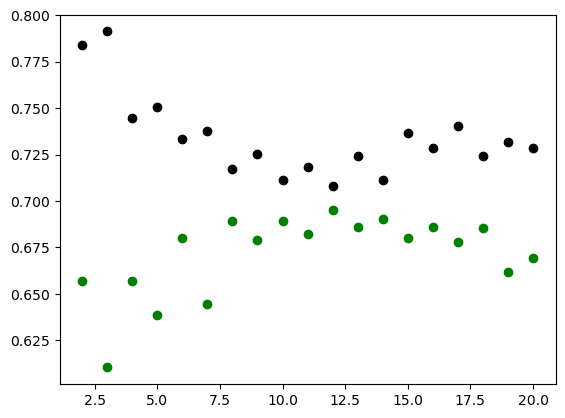

In [34]:
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()
# For overlapping scatter plots

In [35]:
svm = SVC(kernel="poly", degree=1, gamma="scale")

In [36]:
svm.fit(X_train, y_train)

SVC(degree=1, kernel='poly')

In [37]:
y_pred = svm.predict(X_test)

In [38]:
confusion_matrix(y_test, y_pred)

array([[615,  71],
       [275,  27]], dtype=int64)

In [39]:
lr = LogisticRegression()

In [40]:
lr.fit(X_train, y_train)

LogisticRegression()

In [41]:
y_pred = lr.predict(X_test)

In [42]:
y_pred

array(['ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'NORMAL', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'NORMAL', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'NORMAL', 'ANOMALY', 'ANOMALY', 'NORMAL', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'NORMAL', 'NORMAL',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'NORMAL', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'NORMAL', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'NORMAL', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'NORMAL', 'ANOMALY', 'NORMAL', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'ANOMALY', 'NORMAL', '

In [43]:
confusion_matrix(y_test, y_pred)

array([[568, 118],
       [268,  34]], dtype=int64)

In [44]:
y_train_hat_probs = lr.predict_proba(X_test)[:,1]

In [45]:
y_train_hat_probs

array([0.06254675, 0.39873437, 0.38622409, 0.16437957, 0.27118015,
       0.09082793, 0.22177007, 0.3047803 , 0.74999706, 0.12030163,
       0.07690702, 0.18789929, 0.17631081, 0.71111919, 0.19157066,
       0.32249168, 0.39420616, 0.08135514, 0.33479679, 0.18789929,
       0.28760859, 0.18839503, 0.35866357, 0.3501188 , 0.51786023,
       0.2262678 , 0.06795492, 0.62137464, 0.32363805, 0.37629627,
       0.05514744, 0.09300598, 0.05230964, 0.27196844, 0.59733011,
       0.66776475, 0.12095157, 0.22004842, 0.08964282, 0.1875837 ,
       0.07633292, 0.0998339 , 0.0998339 , 0.45318377, 0.217011  ,
       0.05392922, 0.6333798 , 0.12030163, 0.29406105, 0.27106098,
       0.06254675, 0.38811878, 0.22479854, 0.14750043, 0.32481842,
       0.25215624, 0.19955267, 0.32392189, 0.45318377, 0.16437957,
       0.05688438, 0.1285301 , 0.03484654, 0.6354735 , 0.10721706,
       0.40718089, 0.0394385 , 0.14099028, 0.67362624, 0.24124279,
       0.14343168, 0.04519313, 0.70235497, 0.0639797 , 0.63547

In [46]:
nb = GaussianNB()

In [47]:
nb.fit(X_train.toarray(), y_train)

GaussianNB()

In [48]:
y_pred = nb.predict(X_test.toarray())

In [49]:
y_pred

array(['ANOMALY', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'ANOMALY',
       'NORMAL', 'ANOMALY', 'NORMAL', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'NORMAL', 'NORMAL', 'ANOMALY', 'NORMAL', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL',
       'NORMAL', 'ANOMALY', 'ANOMALY', 'NORMAL', 'NORMAL', 'NORMAL',
       'NORMAL', 'ANOMALY', 'ANOMALY', 'NORMAL', 'NORMAL', 'NORMAL',
       'NORMAL', 'ANOMALY', 'ANOMALY', 'NORMAL', 'ANOMALY', 'NORMAL',
       'NORMAL', 'NORMAL', 'NORMAL', 'ANOMALY', 'NORMAL', 'ANOMALY',
       'NORMAL', 'ANOMALY', 'ANOMALY', 'NORMAL', 'NORMAL', 'ANOMALY',
       'ANOMALY', 'ANOMALY', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL',
       'ANOMALY', 'ANOMALY', 'ANOMALY', 'NORMAL', 'ANOMALY', 'NORMAL',
       'ANOMALY', 'NORMAL', 'NORMAL', 'ANOMALY', 'NORMAL', 'ANOMALY',
       'NORMAL', 'ANOMALY', 'NORMAL', 'ANOMALY', 'ANOMALY', 'ANOMALY',
       'ANOMALY', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL',
       'ANOMALY', 'ANOMAL

In [50]:
confusion_matrix(y_test, y_pred)

array([[259, 427],
       [184, 118]], dtype=int64)

In [51]:
lr1 = LinearRegression()

In [52]:
y_train1 = y_train.astype("category").cat.codes
y_test1 = y_test.astype("category").cat.codes


In [53]:
lr1.fit(X_train, y_train1)

LinearRegression()

In [54]:
y_pred = lr1.predict(X_test)

In [55]:
y_pred

array([ 4.15318610e-08,  6.00562242e-01,  3.67019931e-01,  1.42857122e-01,
        2.49999992e-01,  2.12534043e-08,  1.99999967e-01,  1.71863880e-01,
        1.00000009e+00,  3.95285245e-08, -3.29409632e-08, -9.22764676e-09,
       -8.84050379e-08,  1.12944633e+00,  2.00000032e-01,  8.68186983e-08,
        4.15931365e-01, -1.05452880e-09,  3.65829576e-01, -9.22764676e-09,
        4.36346289e-08,  1.66666684e-01,  4.03188524e-01,  5.42755864e-01,
        3.90934894e-01, -8.14676437e-10, -3.73970008e-08,  1.00000012e+00,
        3.33333331e-01,  4.77596839e-01, -3.96940993e-08,  9.94756605e-09,
       -2.06690882e-08,  8.56867901e-08,  9.99999929e-01,  9.99999971e-01,
        8.43917191e-02,  1.79905585e-08, -5.81728887e-08,  1.66666680e-01,
        4.02918642e-08,  1.24980533e-08,  1.24980533e-08,  5.80729189e-01,
        1.99999987e-01,  7.32595590e-09,  1.00000010e+00,  3.95285245e-08,
        5.48053566e-01,  1.54484351e-08,  4.15318610e-08,  3.33333327e-01,
        5.09931697e-02,  

In [56]:
y_pred_lr1 = []
i = 0
for x in y_pred:
    if ( y_pred[i] <= 0 ):
         y_pred_lr1.append(1)
    else:
        y_pred_lr1.append(0)
i += 1


In [57]:
y_pred_lr1

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [58]:
confusion_matrix(y_test1, y_pred_lr1)

array([[686,   0],
       [302,   0]], dtype=int64)